In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from zipfile import ZipFile
file_name='/content/drive/MyDrive/Disease.zip'
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('finish')

finish


In [3]:
from keras.layers import Input, Lambda, Dense, Flatten,GlobalAveragePooling2D, AveragePooling2D,Activation, BatchNormalization
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import layers
import numpy as np
from keras.layers import Dense, Dropout, Flatten
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import os 


In [4]:
pip install -U efficientnet


In [5]:
IMAGE_SIZE = [224, 224]

train_path = '/content/Disease/Dataset/Train'
valid_path = '/content/Disease/Dataset/Test'
test_size='/content/Disease/Dataset/Validation'

In [6]:
pre_trained_model = tf.keras.applications.DenseNet169(include_top = False,
                              input_shape =IMAGE_SIZE + [3],
                              weights = 'imagenet') 

In [7]:
pre_trained_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [8]:
for layer in pre_trained_model.layers:
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True

In [9]:
model= Sequential()
model.add(pre_trained_model) 
model.add(GlobalAveragePooling2D())
model.add( BatchNormalization())
 

In [10]:
model.add(Dense(512,activation=('relu')))
model.add(Dropout(0.2))
model.add(Dense(4,activation=('softmax'))) 

#Checking the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1664)             6656      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               852480    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2

In [11]:
#Intializng callback
from tensorflow import keras
import tensorflow as tf
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


for layer in model.layers:
    layer.trainable = True
adam_fine = keras.optimizers.Adam(lr=0.00006, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
model.compile(optimizer=adam_fine, loss='categorical_crossentropy', metrics=['acc'])

In [13]:
pip install livelossplot

In [14]:
from livelossplot import PlotLossesKeras
from keras.callbacks import ModelCheckpoint, EarlyStopping
plot_loss_1 = PlotLossesKeras()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='best_accuracy.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input,
                                   rescale = 1./255,
                                   shear_range = 0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

Validation_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input,
                                        rescale = 1./255)
Test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
training_set = train_datagen.flow_from_directory('/content/Disease/Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 14813 images belonging to 4 classes.


In [17]:
validation_set = Validation_datagen.flow_from_directory('/content/Disease/Dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 2120 images belonging to 4 classes.


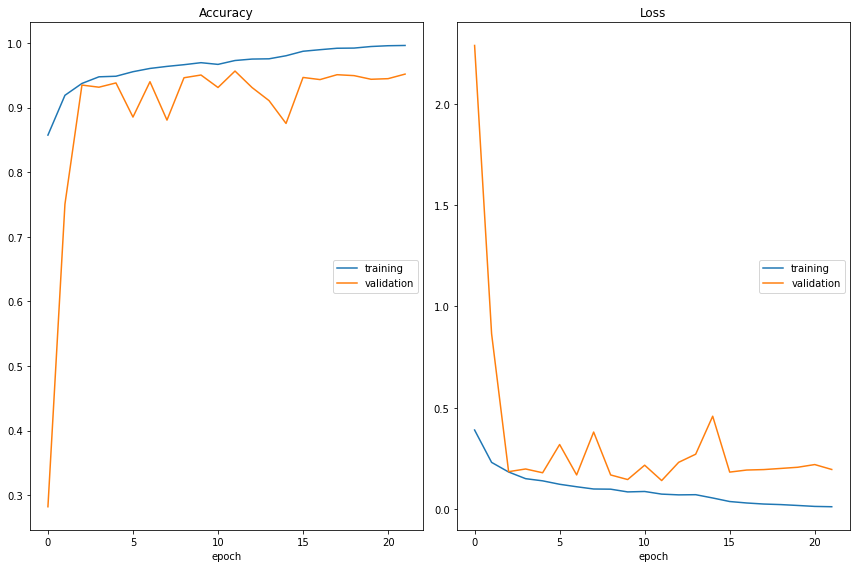

Accuracy
	training         	 (min:    0.857, max:    0.996, cur:    0.996)
	validation       	 (min:    0.282, max:    0.957, cur:    0.952)
Loss
	training         	 (min:    0.011, max:    0.390, cur:    0.011)
	validation       	 (min:    0.141, max:    2.288, cur:    0.195)
463/463 [==============================] - 255s 549ms/step - loss: 0.0115 - acc: 0.9962 - val_loss: 0.1954 - val_acc: 0.9519 - lr: 1.0000e-05
Fitting Time==5657.544922590256


In [18]:
import time
start=time.time()
Model_hist = model.fit_generator(
    training_set,
    validation_data=validation_set,
    epochs=25,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set),
    callbacks=[tl_checkpoint_1, early_stop, plot_loss_1,learning_rate_reduction ],
    verbose=1,
)
end=time.time()
print(f"Fitting Time=={end-start}")

In [19]:
Test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input,
                                  rescale = 1./255)

In [20]:
testgen=Test_datagen.flow_from_directory('/content/Disease/Dataset/Test',
                                         target_size = (224, 224),
                                         batch_size = 64,
                                         class_mode = 'categorical',
                                         shuffle=False)

Found 2120 images belonging to 4 classes.


In [21]:
model.load_weights('/content/best_accuracy.hdf5') # initialize the best trained weights
true_classes = testgen.classes
class_indices = testgen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())
DenseNet201_pred = model.predict(testgen)
DenseNet201_pred_classes = np.argmax(DenseNet201_pred, axis=1)

In [22]:
from sklearn.metrics import accuracy_score
DenseNet201_acc = accuracy_score(true_classes,DenseNet201_pred_classes)
print(" DenseNet201 Model Accuracy  {:.2f}%".format(DenseNet201_acc * 100))

 DenseNet201 Model Accuracy  95.66%


In [23]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, DenseNet201_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       363
           1       0.96      0.93      0.95       602
           2       0.95      0.97      0.96      1020
           3       0.99      0.98      0.99       135

    accuracy                           0.96      2120
   macro avg       0.96      0.96      0.96      2120
weighted avg       0.96      0.96      0.96      2120



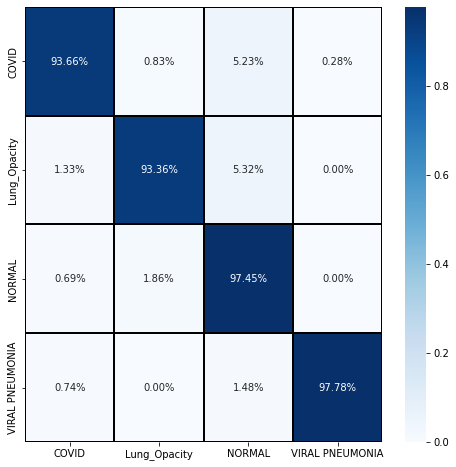

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
cm = confusion_matrix(true_classes, DenseNet201_pred_classes, normalize='true')
class_names = ['COVID','Lung_Opacity','NORMAL','VIRAL PNEUMONIA']
def plot_confusion_matrix (cm):
    plt.figure(figsize = (8,8))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt=".2%", 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

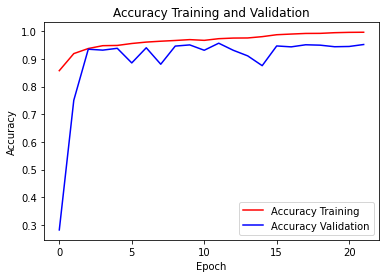

In [25]:
plt.plot(Model_hist.history['acc'], 'r', label='Accuracy Training')
plt.plot(Model_hist.history['val_acc'], 'b', label='Accuracy Validation')
plt.title('Accuracy Training and Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

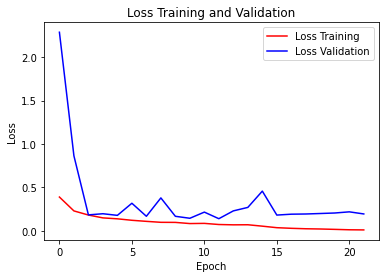

In [26]:
plt.plot(Model_hist.history['loss'], 'r', label='Loss Training')
plt.plot(Model_hist.history['val_loss'], 'b', label='Loss Validation')
plt.title('Loss Training and Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=0)
plt.show()

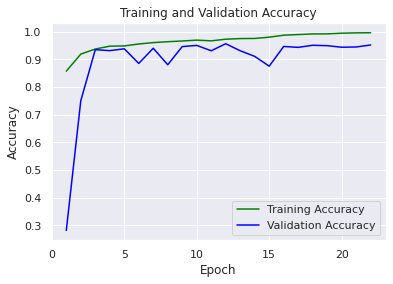

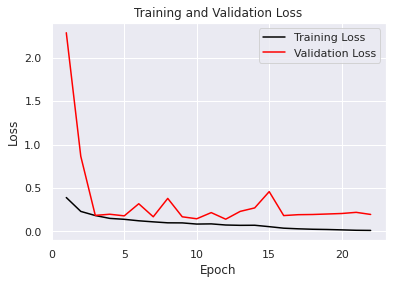

In [27]:
import seaborn as sns
sns.set()

acc = Model_hist.history['acc']
val_acc = Model_hist.history['val_acc']
loss = Model_hist.history['loss']
val_loss = Model_hist.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='black', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


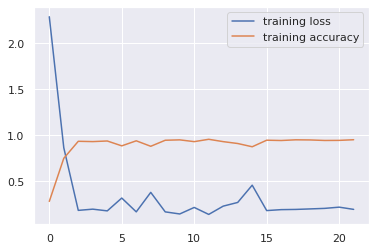

In [28]:
#train data accuracy and loss
plt.plot(Model_hist.history['val_loss'], label = 'training loss')
plt.plot(Model_hist.history['val_acc'], label = 'training accuracy')
plt.legend()

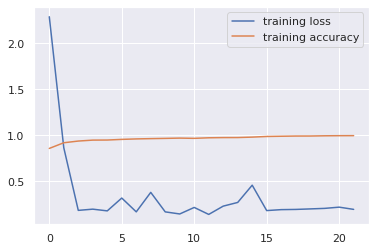

In [29]:
#train data accuracy and loss
plt.plot(Model_hist.history['val_loss'], label = 'training loss')
plt.plot(Model_hist.history['acc'], label = 'training accuracy')
plt.legend()